In [1]:
from myosuite.utils import gym
import skvideo.io
import numpy as np
import os

MyoSuite:> Registering Myo Envs


In [2]:
# from stable_baselines3 import PPO
# policy = "ElbowPose_policy.zip"

# pi = PPO.load(policy)

from stable_baselines3 import PPO
env = gym.make('myoElbowPose1D6MRandom-v0')

env.reset()
pi = PPO("MlpPolicy", env, verbose=0)


pi.learn(total_timesteps=1000)


    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    


/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [3]:
data_store = []
for _ in range(10): # 10 episodes
    for _ in range(100): # 100 samples for each episode
        o = env.get_obs()
        a = pi.predict(o)[0]
        next_o, r, done, *_, ifo = env.step(a) # take a random action
                    
        data_store.append({"action":a.copy(), 
                            "jpos":env.sim.data.qpos.copy(), 
                            "mlen":env.sim.data.actuator_length.copy(), 
                            "act":env.sim.data.act.copy()})

env.close()


/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_obs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_obs` for environment variables or `env.get_wrapper_attr('get_obs')` that will search the reminding wrappers.
  logger.warn(
/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.sim to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sim` for environment variables or `env.get_wrapper_attr('sim')` that will search the reminding wrappers.
  logger.warn(


In [4]:
def VAF(W, H, A):
    """
    Args:
        W: ndarray, m x rank matrix, m-muscles x activation coefficients obtained from (# rank) nmf
        H: ndarray, rank x L matrix, basis vectors obtained from nmf where L is the length of the signal
        A: ndarray, m x L matrix, original time-invariant sEMG signal
    Returns:
        global_VAF: float, VAF calculated for the entire A based on the W&H
        local_VAF: 1D array, VAF calculated for each muscle (column) in A based on W&H
    """
    SSE_matrix = (A - np.dot(W, H))**2
    SST_matrix = (A)**2

    global_SSE = np.sum(SSE_matrix)
    global_SST = np.sum(SST_matrix)
    global_VAF = 100 * (1 - global_SSE / global_SST)

    local_SSE = np.sum(SSE_matrix, axis = 0)
    local_SST = np.sum(SST_matrix, axis = 0)
    local_VAF = 100 * (1 - np.divide(local_SSE, local_SST))

    return global_VAF, local_VAF

/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/xliu227/miniconda3/envs/myosuite/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maxim

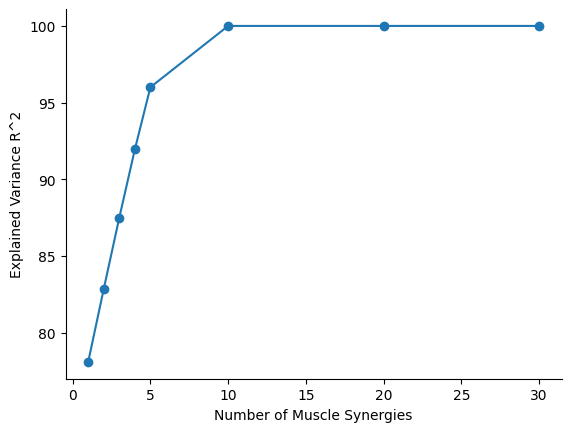

In [5]:
!pip install scikit-learn
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

act = np.array([dd['act'] for dd in data_store])

VAFstore=[]
SSE, SST = [], []

sample_points = [1,2,3,4,5,10,20,30]
for isyn in sample_points:
    nmf_model = NMF(n_components=isyn, init='random', random_state=0);
    W = nmf_model.fit_transform(act)
    H = nmf_model.components_

    global_VAF, local_VAF = VAF(W, H, act)

    VAFstore.append(global_VAF)

plt.plot(sample_points,VAFstore,'-o')
plt.xlabel('Number of Muscle Synergies')
plt.ylabel('Explained Variance R^2')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
